In [19]:
import numpy
import random
import matplotlib.pyplot as plt
#from google.colab import drive

import numpy as np
import pandas as pd
from sklearn import model_selection
import seaborn as sns
plt.style.use('seaborn')

In [20]:
#drive.mount('/content/gdrive')

In [21]:
def sigmoid(inpt):
    return 1.0 / (1.0 + numpy.exp(-1 * inpt))

def relu(inpt):
    result = inpt
    result[inpt < 0] = 0
    return result

def tanh(inpt):
    return (2*sigmoid(2*inpt) - 1)

#Genetic Algorithm

In [22]:
def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

In [23]:
def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = numpy.uint32(offspring_size[1]/2)
    
    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

In [24]:
def mutation(offspring_crossover, mutation_percent):
    num_mutations = numpy.uint32((mutation_percent*offspring_crossover.shape[1])/100)
    mutation_indices = numpy.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))

    # Mutation changes a single gene in each offspring randomly.

    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        random_value = numpy.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    return offspring_crossover

# Changing weight matrices to 1-D vectors

In [25]:
def mat_to_vector(mat_pop_weights):
    pop_weights_vector = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = numpy.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        pop_weights_vector.append(curr_vector)
    return numpy.array(pop_weights_vector)

# Changing 1-D vectors to weight matrices

In [26]:
def vector_to_mat(vector_pop_weights, mat_pop_weights):
    mat_weights = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[sol_idx, layer_idx].size
            curr_vector = vector_pop_weights[sol_idx, start:end]
            mat_layer_weights = numpy.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return numpy.reshape(mat_weights, newshape=mat_pop_weights.shape)

# Muliplying weights with input to predict output**

In [27]:
def predict_outputs(weights_mat, data_inputs, data_outputs, activation):
    predictions = numpy.zeros(shape=(data_inputs.shape[0]))
    for sample_idx in range(data_inputs.shape[0]):
        r1 = data_inputs[sample_idx, :]
        for curr_weights in weights_mat:
            r1 = r1 @ curr_weights
            if activation == "relu":
                r1 = relu(r1)
            elif activation == "sigmoid":
                r1 = sigmoid(r1)
        predicted_label = numpy.where(r1 == numpy.max(r1))[0][0]
        predictions[sample_idx] = predicted_label
    correct_predictions = numpy.where(predictions == data_outputs)[0].size
    accuracy = (correct_predictions/data_outputs.size)*100
    return accuracy, predictions

# Fitness Function

In [28]:
def fitness(weights_mat, data_inp, data_out, activation):
    accuracy = numpy.empty(shape=(weights_mat.shape[0]))
    for sol_idx in range(weights_mat.shape[0]):
        curr_sol_mat = weights_mat[sol_idx, :]
        accuracy[sol_idx], _ = predict_outputs(curr_sol_mat, data_inp, data_out, activation=activation)
    return accuracy

# Read the dataset 

In [29]:
def normalize(dataset):
    dataNorm=((dataset-dataset.mean())/(dataset.std()))
    dataNorm["Sad?"]=dataset["Sad?"]
    return dataNorm

In [30]:
df = pd.read_csv('combined.csv')
df=df.drop(['face'],1)
df=df.drop(['Unnamed: 1'],1)
print(df)
  
df = normalize(df)
#df=df.drop('Unnamed: 1',axis=1,inplace=True)

x = np.array(df.drop(['Sad?'],1))
y = np.array(df['Sad?'])
x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size=0.2)

data_inputs = x_train
data_outputs = y_train

     Sad?  confidence  gaze_0_x  gaze_0_y  gaze_0_z  gaze_1_x  gaze_1_y  \
0       1       0.975  0.045100  0.261753 -0.964081 -0.059101  0.220275   
1       1       0.925  0.058224  0.235082 -0.970230 -0.056113  0.216628   
2       1       0.975  0.074234  0.026665 -0.996884 -0.046497  0.029027   
3       1       0.025  0.256086 -0.216004 -0.942212  0.120141 -0.217794   
4       1       0.975  0.193449  0.209023 -0.958586  0.032758  0.185837   
..    ...         ...       ...       ...       ...       ...       ...   
121     0       0.875 -0.263258 -0.049040 -0.963478 -0.421201  0.028245   
122     0       0.775  0.509802 -0.322897 -0.797395  0.363785 -0.345633   
123     0       0.975  0.183691  0.158997 -0.970040  0.015769  0.152994   
124     0       0.975 -0.010093  0.216590 -0.976210 -0.023248  0.208353   
125     0       0.975  0.145005  0.166456 -0.975329 -0.087870  0.193869   

     gaze_1_z  gaze_angle_x  gaze_angle_y  ...  AU12_c  AU14_c  AU15_c  \
0   -0.973646        -0.0

In [40]:
def GA(sol_per_pop,num_parents_mating,num_generations,mutation_percent,HL1_neurons,HL2_neurons,output_neurons,activation):
  print("Population size : " + str(sol_per_pop))
  print("Mating Pool Size (Number of Parents) :" + str(num_parents_mating))
  print("Number of generations : " + str(num_generations))
  print("Mutation Percent : " + str(mutation_percent))
  print("Activation : " + str(activation) + "\n")

  initial_pop_weights = []
  data_inputs = x_train
  data_outputs = y_train
  for curr_sol in numpy.arange(0, sol_per_pop):

      input_HL1_weights = numpy.random.uniform(low=-0.1, high=0.1, size=(data_inputs.shape[1], HL1_neurons))
      HL1_HL2_weights = numpy.random.uniform(low=-0.1, high=0.1, size=(HL1_neurons, HL2_neurons))
      HL2_output_weights = numpy.random.uniform(low=-0.1, high=0.1, size=(HL2_neurons, output_neurons))
      initial_pop_weights.append(numpy.array([input_HL1_weights, HL1_HL2_weights, HL2_output_weights]))

  pop_weights_mat = numpy.array(initial_pop_weights)
  pop_weights_vector = mat_to_vector(pop_weights_mat)
  best_outputs = []
  accuracies = numpy.empty(shape=(num_generations))
  for generation in range(num_generations):

    if(generation %100 == 0):
      print("Generation : ", generation)
    # converting the solutions from being vectors to matrices.
    pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

    # Measuring the fitness of each chromosome in the population.
    
    fit = fitness(pop_weights_mat, data_inputs, data_outputs, activation=activation)
    accuracies[generation] = fit[0]

    # print("Fitness")
    # print(fit)

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(pop_weights_vector, fit.copy(), num_parents_mating)

    # print("Parents")
    # print(parents)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], pop_weights_vector.shape[1]))

    # print("Crossover")
    # print(offspring_crossover)

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)

    # print("Mutation")
    # print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    pop_weights_vector[0:parents.shape[0], :] = parents
    pop_weights_vector[parents.shape[0]:, :] = offspring_mutation
  pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)
  best_weights = pop_weights_mat [0, :]
  acc, predictions = predict_outputs(best_weights, data_inputs, data_outputs, activation=activation)
  print("\n")
  print("Accuracy of the best solution is : ", acc)
  plt.plot(accuracies)
  plt.xlabel("No of Generations")
  plt.ylabel("$Fitness(\Theta)$")
  plt.title("Plot of Fitness Function v/s Generations")
  plt.show()
  data_inputs=x_test
  data_outputs=y_test
  acc, predictions = predict_outputs(best_weights, data_inputs, data_outputs, activation=activation)
  print("Testing Accuracy of the best solution is : ", acc)

Population size : 8
Mating Pool Size (Number of Parents) :2
Number of generations : 1000
Mutation Percent : 10
Activation : tanh

Generation :  0
Generation :  100
Generation :  200
Generation :  300
Generation :  400
Generation :  500
Generation :  600
Generation :  700
Generation :  800
Generation :  900


Accuracy of the best solution is :  86.0


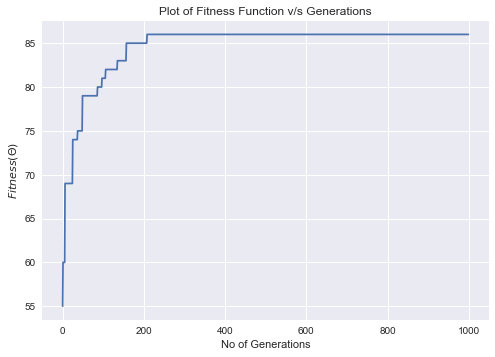

Testing Accuracy of the best solution is :  73.07692307692307


In [45]:
GA(sol_per_pop = 8,num_parents_mating = 2,num_generations = 1000,mutation_percent = 10,HL1_neurons = 150,HL2_neurons = 60,output_neurons = 2,activation = "tanh")

In [33]:
def garson(A, B, C):
    """
    Computes Garson's algorithm
    A = matrix of weights of input-hidden layer (rows=input & cols=hidden)
    B = vector of weights of hidden-output layer
    """

    # connection weight through the different hidden node
    cw = np.dot(A, B)
    cw = np.dot(cw, C)

    # weight through node (axis=0 is column; sum per input feature)
    cw_h = abs(cw).sum(axis=0)

    # relative contribution of input neuron to outgoing signal of each hidden neuron
    # sum to find relative contribution of input neuron
    rc = np.divide(abs(cw), abs(cw_h))
    rc = rc.sum(axis=1)

    # normalize to 100% for relative importance
    ri = rc / rc.sum()
    return(ri)

In [34]:
g1=garson(best_weights[0],best_weights[1],best_weights[2])
features=df.columns
Dict = {}
for i in range(1,711):
  Dict[features[i]]=g1[i-1]

NameError: name 'best_weights' is not defined

In [ ]:
import operator
sorted_x = sorted(Dict.items(), key=operator.itemgetter(1),reverse=True)
print("Printing features ranked from most important to least important")
x=0
for i in sorted_x:
  print(x,":",i)
  x=x+1